In [128]:
#import the necessary libraries
import numpy as np
import timeit
from matplotlib import pyplot as pl
from scipy.integrate import quad, simpson as sci_simp #accurate integration function

In [129]:
pl.style.use("~/Documents/configs/custom.mplstyle")

# Problem 1

In [130]:
# Function for rectangle rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
#          - dx: the interval width
def rect(f, a, b, n):
    #initialize the integral and error
    tot, err = 0, 0

    #compute the interval width
    dx = (b - a)/n

    #initialize the independent variable to the lower bound
    x = a

    #initalize a value to store an additional function call
    #to avoid doubled function calls when estimating error
    next_val = f(a)

    #initialize variable for function values
    val = 0

    #loop to upper bound
    while x < b:
        #shift the next function value to be current
        val = next_val
        #add function value to running sum (without dx factor)
        tot += val
        #increment independent variable
        x += dx
        #compute the next function value
        next_val = f(x)
        #estimate the error using approximate area of triangle
        #formed by the current and next function values
        err += dx * abs(val-next_val) / 2

    #returning while multiplying by common dx factor
    return tot*dx, err, dx




# Function for the rectangle rule implemented using numpy vectorization
# (Performs the same computation as rect)
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - the definite integral result
#          - err: an estimate of the error on tot
def rect_vec(f, a, b, n):
    #initialize independent variable array n long [a,b-dx]
    #holding the left edges of the rectangles
    xs = np.linspace(a, b, int(n+1))[:-1]
    #compute rectangle widths
    dx = (xs[1]-xs[0])

    #evaluate the function at all the x values "simultaneously" using 
    #  numpy vectorization
    #the vectorize function works but I found it increases runtime
    #  substantially due to apparent overhead
    #for simple arithmetic functions, numpy's built in vectorization
    #  does not incur this additional overhead
    ## vals = np.vectorize(f)(xs)
    vals = f(xs)
    
    #estimate error using the same idea as rect() but using array vectorization
    err = 0.5 * np.sum(np.abs(vals[1:]-vals[:-1])) * dx
    
    return np.sum(vals)*dx, err




# Function that computes integral using rectangles with height evaluated at their centers
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def rect_cen(f, a, b, n):
    #initialize the integral and error
    tot, err = 0, 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to be the center of the rectangle
    #  rather than the left edge
    x = a + dx/2
    #initialize variables to store current and upcoming function
    #  values to avoid duplicated function calls
    val = 0
    next_val = f(x)

    #estimate error using the areas of triangles formed at the 
    #  beginning and end of the integration interval
    err = abs(next_val - f(a)) / 2 * dx

    #loop over the interval of integration
    while x < b:
        #using the function value computed previously
        val = next_val
        #adding to the running sum
        tot += val
        #incrementing x
        x += dx
        #computing next function value
        next_val = f(x)

    #returning while multiplying by common dx factor
    return tot*dx, err



# Function for the trapezoid rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def trap(f, a, b, n):
    #initialize the integral
    tot = 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to its second value since next_val will
    #  already hold f(a+dx) so we don't want to duplicate this
    #  after the first loop evaluation

    #initialize variables to store current and upcoming function
    #  values to avoid duplicated function calls
    val = f(a)
    next_val = f(a+dx)
    i=1
    #loop over the interval of integration
    while i <= n:
        #adding to the running integral 
        tot += (val + next_val)
        #shifting to the next function value
        val = next_val
        #incrementing x
        i += 1
        #computing next function value
        next_val = f(a+i*dx)

    #returning while multiplying by common dx factor
    #rather than estimating second derivatives to get an error
    # estimate, I'll just use dx^2 scaled to the tot
    return tot*dx/2, abs(tot)*dx**3 / 2


# Function for the trapezoid rule for integration using numpy vectorization
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - tot: the definite integral result
#          - err: an estimate of the error on tot
def trap_vec(f, a, b, n):
    #initialize the integral
    tot = 0
    #compute the interval width
    dx = (b - a)/n
    #initializing x to its second value since next_val will
    #  already hold f(a+dx) so we don't want to duplicate this
    #  after the first loop evaluation
    xs = np.linspace(a, b, n+1)
    fs = f(xs)

    tot = 0.5 * (np.sum(fs[:-1] + fs[1:])) * dx

    #rather than estimating second derivatives to get an error
    # estimate, I use a very bad estimation assuming f'' ~ dx
    return tot, abs(tot)*dx**2 / 2



# Function for Simpson's rule for integration
# Inputs: - f: 1d function to integrate
#         - a: lower bound
#         - b: upper bound
#         - n: number of intervals to divide the integration into
# Returns: - the definite integral result
#          - err: an estimate of the error on tot
def simpson(f, a, b, n):

    #ensure that n is even
    if(n%2==1):
        n+=1

    #compute interval widths
    dx = (b - a)/n

    #generate grid of x values
    xs = np.linspace(a,b,n+1)

    #precompute all the function values and save to array
    fx = f(xs)

    #add the endpoints which don't have prefactors
    tot = fx[0]+fx[-1]

    #loop over indicies 1,3,...,n-3 to avoid double loop
    for i in range(1, n-1, 2):
        #get odd indicies with i and even with i+1
        tot += 4*fx[i]+2*fx[i+1]

    #add in final a+(N-1)dx element (since odd sum has one extra term in equation)
    tot+=4*fx[-2]

    #returning while multiplying by common dx/3 factor
        #rather than estimating third derivatives to get an error
        # estimate, I'll just use dx^3 scaled to tot
    return tot*dx/3, abs(tot)*dx**4 / 3


In [131]:
#Define the target function for integration
# f takes x and returns x^-3/2
f = lambda x: x**(-3/2)

#define the bounds on the integral
a, b = 1, 5

We can notice that $\int^5_1 \frac{1}{x^{3/2}} dx$ is an analytical integral. The solution is easily found to be $2 [1^{1/2} - 5^{1/2}]$. I evaluate this in the next cell and save it to a variable 'truth' to compare our numerical integrals against.

In [132]:
truth = 2 * (1 - 5**-0.5)
print(truth)

1.1055728090000843


In [133]:
N = np.logspace(np.log10(5),np.log10(2000),50, dtype=int)

res = np.zeros((len(N),4,3))
step_size = np.zeros(len(N))

for i,n in enumerate(N):
    res[i,0,0], res[i,0,1], step_size[i] = rect(f, a, b, n)
    res[i,1,0], res[i,1,1] = rect_cen(f, a, b, n)
    res[i,2,0], res[i,2,1] = trap(f, a, b, n)
    res[i,3,0], res[i,3,1] = simpson(f, a, b, n)
    res[i,:,2] = np.abs(res[i,:,0] - truth)/truth

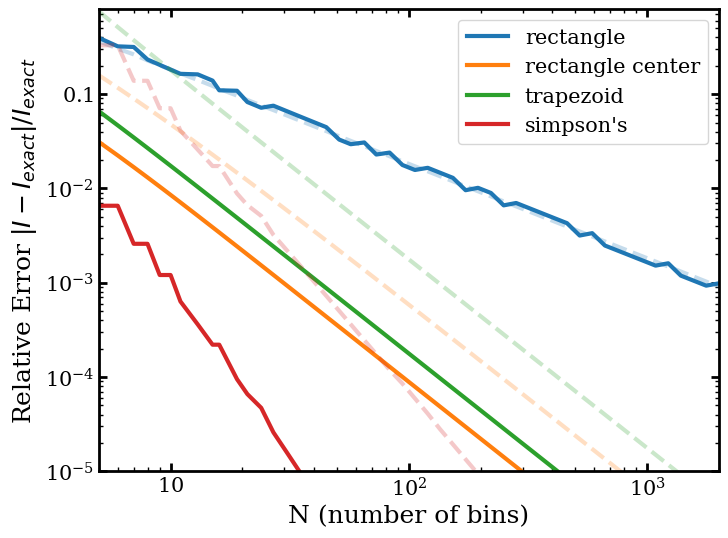

In [134]:
pl.figure(figsize=(8,6))
labs = ['rectangle', 'rectangle center', 'trapezoid', "simpson's"]
for i in range(len(labs)):
    pl.plot(N, res[:,i,2], label=labs[i])
    pl.plot(N, res[:,i,1], ls='--', alpha=0.25, c="C"+str(i))
pl.ylim(bottom=1e-5)
pl.yscale("log")
pl.xscale("log")
pl.legend()
pl.xlabel("N (number of bins)")
pl.ylabel(r"Relative Error $|I-I_{exact}|/I_{exact}$")
pl.show()

In [135]:
calls = ['rect(f,a,b,N)',
         'rect_vec(f,a,b,N)',
         'rect_cen(f,a,b,N)',
         'trap(f,a,b,N)',
         'trap_vec(f,a,b,N)',
         'simpson(f,a,b,N)']


times = np.zeros((len(N), len(calls), 2))
for j in range(len(N)):
    for i in range(len(calls)):
        temp = timeit.repeat(calls[i].replace("N", str(N[j])), number=1000, repeat=5, globals=globals())
        times[j,i,0], times[j, i,1] = np.mean(temp)/1000, np.std(temp)/1000

KeyboardInterrupt: 

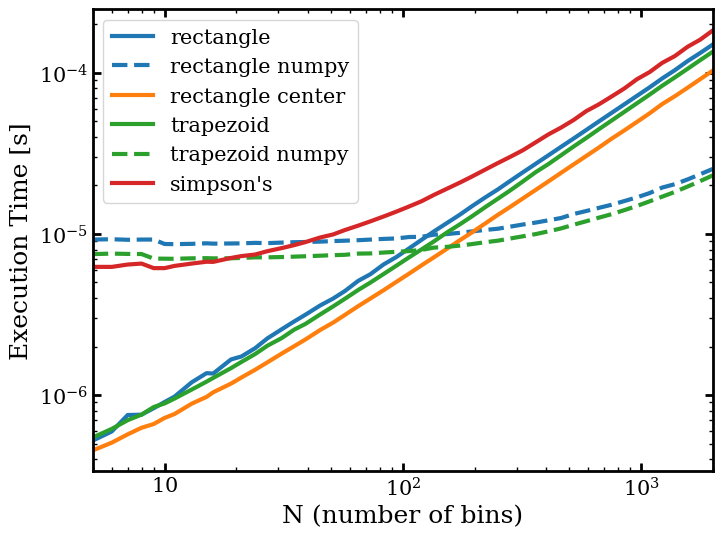

In [238]:
pl.figure(figsize=(8,6))
cols = ["C0", "C0", "C1", "C2", "C2", "C3"]
lss = [None, '--', None, None, '--', None]
labs = ["rectangle", "rectangle numpy", "rectangle center", "trapezoid",
        "trapezoid numpy", "simpson's"]
for i in range(len(calls)):
    pl.plot(N,times[:,i,0], c=cols[i], ls=lss[i], label=labs[i])

pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.xlabel("N (number of bins)")
pl.ylabel("Execution Time [s]")
pl.show()

# Problem 2

In [141]:
rng = np.random.default_rng(31415)

m_total = 1e12 # solar masses
a = 35. # kpc
N = 1e6 # number of particles
G = 4.30092e-6 # kpc km2 / M_sol / s2

In [ ]:
fE_int_tab = np.zeros((2,1e5))
fE_int_tab[0,:] = np.logspace(-3,-phi())

In [187]:
def hernquist(r, a=a, M=m_total):
    return M*a/(2*np.pi * r * (r+a)**3)

def m_r(r, a=a, M=m_total):
    return M * r**2 / (r+a)**2

def r_m(m, a=a, M=m_total):
    return a/((M/m)**0.5 - 1)

def phi(r, a=a, M=m_total):
    return -G*M/(r+a)

def f_E(E, a=a, M=m_total):
    q = np.sqrt(-a*E/G/M)
    vg = np.sqrt(G*M/a)
    out = np.zeros(len(E))
    mask = q < 1
    qm = q[mask]
    out[mask] = M / (8 * 2**0.5 * np.pi**3 * vg**3 * (1-qm**2)**(5/2)) * \
        (3*np.arcsin(qm) + qm*(1-qm**2)**0.5 * (1-2*qm**2) * (8*qm**4-8*qm**2-3))
    return out

def p_er(e,r):
    ps = np.zeros(len(e))
    cond = (e >= phi(r)) & (e <= 0)
    ps[cond] = f_E(e[cond]) * np.sqrt(e[cond] - phi(r[cond]))
    return ps

def bound(e, r):
    return f_E(e) * np.sqrt(-phi(r))

    #return e**(5/2) / norm * np.sqrt(10)/np.sqrt(r)

def inv_bound_cdf(x, r):
    return np.interp(x, fE_int_tab[1,:], fE_int_tab[0,:])


def sample_Es(rs, phis):

    cdf_norm = np.interp(-phis, -fE_int_tab[0,:], fE_int_tab[1,:] )
    rands = rng.random(len(rs)) * cdf_norm
    Es = inv_bound_cdf(rands, rs)

    mult_factor = bound(phis, rs)
    reject_rands = rng.random(len(rs)) * mult_factor
    Es[reject_rands > p_er(Es,rs)] = 0
    return Es


def v2_mean(r, a=a, M=m_total):
    return G*M / 12 / a * (12*r * (r+a)**3 / a**4 * np.log((r+a)/r) \
             - r / (r+a) * (25 + 52* r/a + 42* (r/a)**2 + 12* (r/a)**3))


In [113]:
fE_int_tab = np.zeros((2,int(1e5)))
fE_int_tab[0,:] = -np.logspace(-3,np.log10(G*m_total/a-1), int(1e5))
fEs = f_E(fE_int_tab[0,:])
for i in range(1,len(fE_int_tab[0])):
    fE_int_tab[1,i] = fE_int_tab[1,i-1] + sci_simp(fEs[i-1:i+1], -fE_int_tab[0,i-1:i+1])

In [202]:
radii = rng.random(int(N)) * m_total #technically masses
radii = r_m(radii)
phis = phi(radii)
Es = np.zeros(len(radii))
is_zero = (Es == 0)
while sum(is_zero) > 0:
    Es[is_zero] = sample_Es(radii[is_zero], phis[is_zero])
    is_zero = (Es == 0)
    
vs = np.sqrt(2 * (Es - phis))
v_pol_ang = np.arccos(2 * rng.random(len(vs)) - 1)
vr = vs * np.cos(v_pol_ang)

sort_r = np.argsort(radii)
radii = radii[sort_r]
vr = vr[sort_r]

bin_edges = np.logspace(np.log10(min(radii)), np.log10(max(radii)), 100)
bin_mid = bin_edges[:-1] * np.sqrt(bin_edges[1]/bin_edges[0])

vr_binned = np.zeros(len(bin_mid))
count_binned = np.zeros(len(bin_mid))

for i in range(len(bin_mid)):
    mask = (radii >= bin_edges[i]) & (radii < bin_edges[i+1])
    vr_binned[i] = np.mean(vr[mask]**2)
    count_binned[i] = sum(mask)

1000000


/home/owen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/owen/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


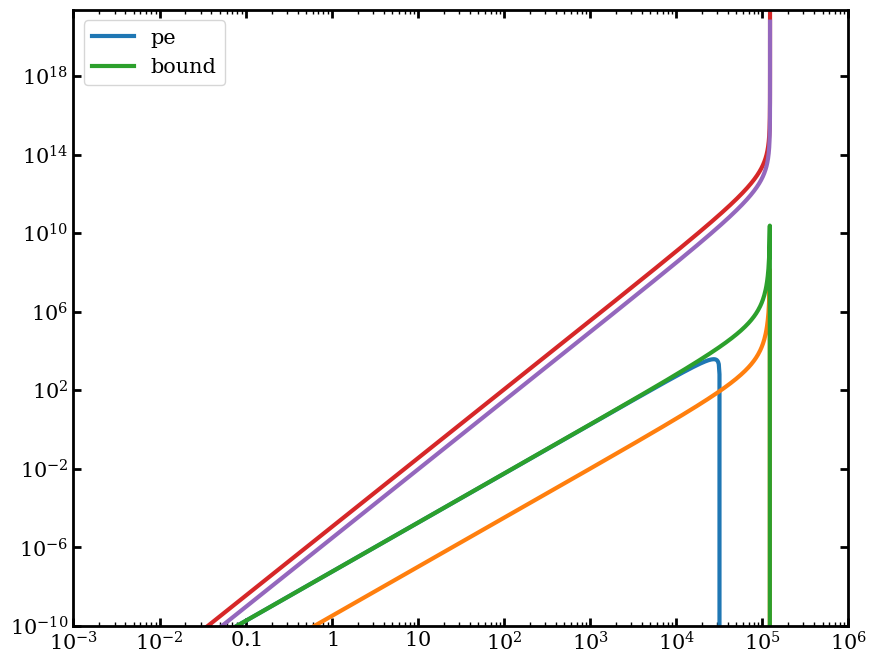

In [168]:
x = np.logspace(-2, 6, 1000)
#rs = np.ones(len(x))*2
r = np.ones(len(x))*100
#cap = 2 * (-phi(r))**(7/2) / 7

#bound = np.where(x < -phi(r)/2, x**(5/2)/3e6 / r**(1/3), ((x + phi(r)/2 -1)**(3)/3e6/r**(1/3))+((-phi(r)/2)**(5/2)/3e6 / r**(1/3)))

pl.plot(x, p_er(-x, r), label="pe")
pl.plot(x, f_E(-x))
#pl.plot(x, f_E(-x)*np.sqrt(x))
pl.plot(x, bound(-x, r), label="bound")#m_total**0.5)
pl.plot(-fE_int_tab[0,:], fE_int_tab[1,:] * -phi(1))
pl.plot(-fE_int_tab[0,:], fE_int_tab[1,:] * -phi(100))

#pl.plot(x, f_E(-x)*np.sqrt(-phi(r)) / p_er(-x, r), label="diff")
#pl.plot(x, x**(5)/3e6/r**(1/3))
#pl.plot(x, 2/7*x**(7/2))
#pl.hlines([cap], 1e-2, 1e6)
#pl.vlines([-phi(r)],1e-2, 1e18)
pl.ylim(bottom=1e-10)
pl.yscale('log')
pl.xscale('log')
pl.legend()
pl.show()

In [183]:
print(fE_int_tab[1,-5000:-4990])

[4030379.78533144 4033572.64188099 4036768.20718748 4039966.48376105
 4043167.47411438 4046371.18076277 4049577.6062241  4052786.75301886
 4055998.62367015 4059213.22070361]


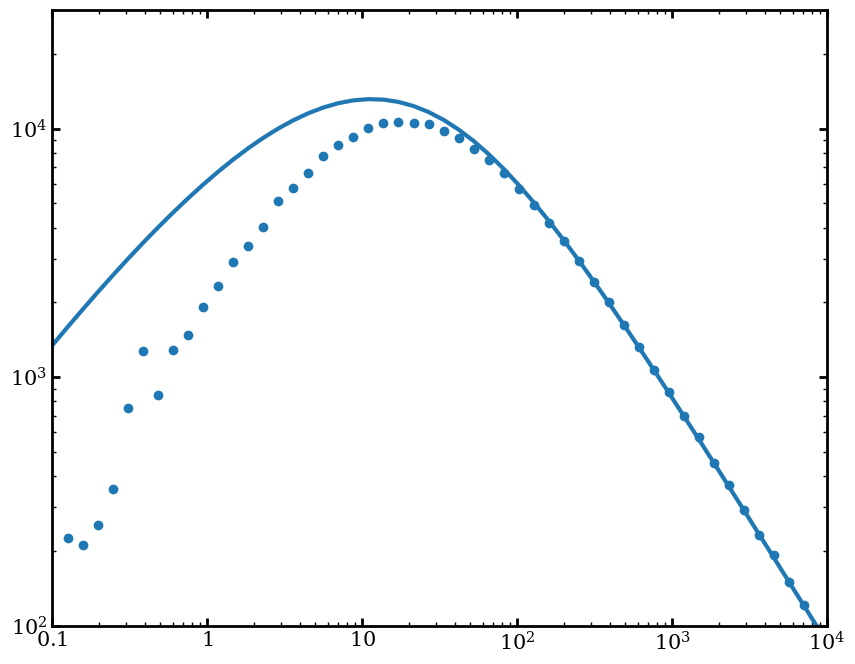

In [209]:
vs = v2_mean(bin_mid)

pl.plot(bin_mid, np.abs(vs))
pl.scatter(bin_mid, 1.5*vr_binned)
pl.xlim(0.1,1e4)
pl.ylim(1e2, 3e4)
pl.xscale('log')
pl.yscale('log')
pl.show()

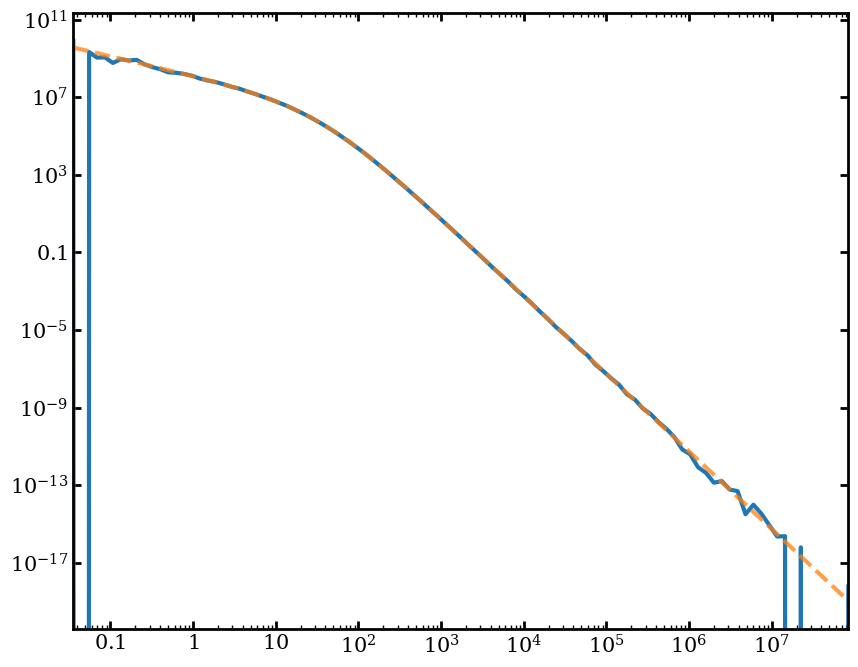

In [162]:
rho_bin = count_binned * (m_total / N) / (4 * np.pi * bin_mid**3 * np.log10(bin_mid[1]/bin_mid[0]) * np.log(10))

hern_bin = hernquist(bin_mid) * 4 * np.pi * bin_mid**3

#pl.loglog(bin_mid, count_binned)
#pl.plot(bin_mid, hern_bin)
pl.loglog(bin_mid, rho_bin)
pl.plot(bin_mid, hernquist(bin_mid), alpha=0.75, ls='--')
pl.show()

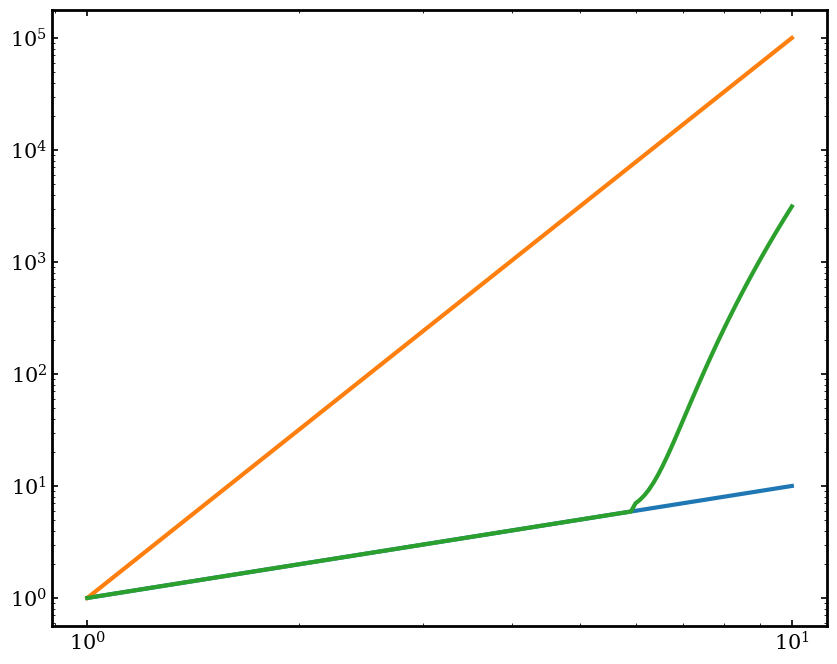

In [28]:
x = np.linspace(1,10,100)

f1 = lambda x: x
f2 = lambda x: x**(5)
ex = lambda x: np.exp(x)
f3 = np.where(x < 6, f1(x), f2(x-5)+f1(6))

pl.plot(x, f1(x))
pl.plot(x, f2(x))
pl.loglog(x, f3)


pl.show()

In [ ]:
v_az_ang = rng.random(len(vs)) * 2 * np.pi
v_pol_ang = np.arccos(2 * rng.random(len(vs)) - 1)
vvec=np.zeros((len(vs), 3))
vvec[:,0]=vs*np.sin(v_pol_ang)*np.cos(v_az_ang)
vvec[:,1]=vs*np.sin(v_pol_ang)*np.sin(v_az_ang)
vvec[:,2]=vs*np.cos(v_pol_ang)

pos_az_ang = rng.random(len(vs)) * 2 * np.pi
pos_pol_ang = np.arccos(2 * rng.random(len(vs)) - 1)
posvec=np.zeros((len(vs), 3))
posvec[:,0]=np.sin(pos_pol_ang)*np.cos(pos_az_ang)
posvec[:,1]=np.sin(pos_pol_ang)*np.sin(pos_az_ang)
posvec[:,2]=np.cos(pos_pol_ang)

*np.exp((x+phi(r)/3)/(-phi(r)/7))